## Introduction:  Project 11
This notebook creates vacation brochures for 3 destinations across the Universe based on estimated flight distance & time from Earth, temperature, and atmosphere. We will have a list of 8 possible stars and planets you can visit while utilizing LLM API calls to generate 2 activites with date, time, and a 2 sentence brief description. Each brocherure contains the destination name, description of destination that is stored as an attribute of the SpaceDestination class, specs (distance, travel time, etc), and a cheap and expensive version of activities as well as a cost estimate.


In [77]:
# pip installs and dependencies (not all of them yet added)

%pip install openai anthropic python-dotenv


Note: you may need to restart the kernel to use updated packages.


In [78]:
#setup and imports (add below, not done)
from openai import OpenAI
import os
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Get the API key from the environment variable
api_key = os.getenv("OPENAI_API_KEY")

# Initialize the OpenAI client with the API key
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

#claude api
import os
from anthropic import Anthropic

claude_api_key = os.getenv("CLAUDE_API_KEY")
claude_client = Anthropic(api_key=claude_api_key) if claude_api_key else None


### Class Initialization for SpaceDestination and TourPackage
---
SpaceDestination
- Name: string
- Distance: float (furtherest astronomical unit from Earth)
- Cost: $100 * (astronomical units)
- Description: short paragraph

Activity
- generated by LLM API call

TourPackage
- Destination: SpaceDestination object
- Tier: VIP or Budget
- Activity 1: Activity object
- Activitiy 2: Activity object

In [79]:
class SpaceDestination:
    def __init__(self, name, distance, description):
        self.name = name
        self.distance = distance
        self.cost = round(100 * float(distance), 2)
        self.description = description

    def __str__(self):
        return f"{self.name}\n\nBase Cost:{self.cost}\tDistance:{self.distance}\n{self.description}"


class Activity:
    def __init__(self, name, date, time, cost, description):
        self.name = name
        self.date = date
        self.time = time
        self.cost = cost
        self.description = description
    def __str__(self):
        return f"{self.name}\n\nDate & Time: {self.date}\t{self.time}\t\tCost:{self.cost}\n{self.description}"

class TourPackage:
    def __init__(self, destination, tier, activity1, activity2, activity3, activity4):
        self.dest = destination
        self.tier1 = 'Budget'
        self.act1 = activity1
        self.act2 = activity2
        self.tier2 = 'VIP'
        self.act3 = activity3
        self.act4 = activity4
    
    def __str__(self):
        return (f"Tour Package Tier: {self.tier1}\n"
        f"Activity 1: {self.act1}"
        f"\n\n\nActivity 2: {self.act2}"
        
        f"Tour Package Tier: {self.tier2}\n" 
        f"Activity 1: {self.act3}" 
        f"\n\n\nActivity 2: {self.act4}")

In [80]:
#List of 8 chooseable destinations
locations = []
locations.append(SpaceDestination("Mars", 2.5, "Desert-like rocky planet with a tenuous atmosphere."),)
locations.append(SpaceDestination("Jupiter", 6.2, "Gas giant known for its colorful, swirling cloud bands and the Great Red Spot"),)
locations.append(SpaceDestination("Uranus", 20.1, "Cold, blue-green, ice giant"),)
locations.append(SpaceDestination("Pluto", 50, "Dwarf planet in the Kuiper Belt featuring varied terrain"),)
locations.append(SpaceDestination("Mercury", 1.45, "Features a rocky surface, a large iron core, and extreme temperature variations"),)
locations.append(SpaceDestination("Saturn", 10.07, "Gas giant with a prominent ring system made of ice and dust and massive gaseous atmosphere"),)
locations.append(SpaceDestination("Ceres", 3.1, "Dwarf planet known for its high water ice content,"),)
locations.append(SpaceDestination("Orcus", 48.91, "Dwarf planet in the Kuiper Belt rich in crystalline water ice"),)

# List of indexes in locations that you are adding TourPackage to
#selected_locations = []
#count = 3

# User selects 3 locations to make tour packages for
#while(count > 0):
    #choice = input("Choose a location between 1-8: ")
    #selected_locations.append(float(choice)-1)
    #count-= 1



In [81]:
#Calculations (NumPy arrays for distances/times/costs) (add below)
# since I think we have the calculations done in the classes already, we might now need this. was numpy a requirment of the project?

In [82]:
# MatPlotLib: plotting function for LLM-selected destinations

import matplotlib.pyplot as plt
import numpy as np

def plot_selected_destinations(selected_destinations, user_goals):
    """Simple plots for the 3 destinations LLM chose"""
    
    # Get data for selected destinations
    names = [dest.name for dest in selected_destinations]
    costs = [dest.cost for dest in selected_destinations]
    distances = [dest.distance for dest in selected_destinations]
    
    # Plot 1: bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(names, costs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.title(f'Costs for Your Tour')
    plt.ylabel('Cost ($)')
    plt.xlabel('Destinations')
    plt.show()
    
    # Plot 2: scatter plot
    plt.figure(figsize=(8, 5))
    plt.scatter(distances, costs, s=100, c=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    for i, name in enumerate(names):
        plt.annotate(name, (distances[i], costs[i]), xytext=(5, 5), textcoords='offset points')
    plt.title('Distance vs Cost')
    plt.xlabel('Distance (AU)')
    plt.ylabel('Cost ($)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    #print(f"Your tour: {', '.join(names)}")

In [83]:
#Brochure formatting: make the brochure look polished and put together (possible with color and different text types or sizes)
#note(delete note later): currently, the brochure is printed at the bottom of the LLM integration cell, so that might have to be changed

Welcome to Space Tourism!
What are your goals/constraints? (e.g., 'budget-friendly', 'luxury experience', 'adventure', 'relaxation')

=== Jupiter Space Tour ===
Distance: 6.2 AU | Cost: $620.0
1. Celestial Spa Retreat ($310.0): Indulge in a zero-gravity massage experience while floating in a luxurious spa pod, surrounded by holographic views of Jupiter's swirling clouds.
2. Jovian Gourmet Dinner ($496.0): Savor a multi-course meal crafted by top intergalactic chefs, featuring exotic ingredients sourced from Jupiter's moons, all while dining in a transparent dome with panoramic views of the Great Red Spot.
3. Aurora Borealis Balloon Ride ($744.0): Take a romantic hot air balloon ride above Jupiter's atmosphere, witnessing breathtaking auroras and vibrant storms, complete with a champagne toast as you float among the clouds.
--------------------------------------------------

=== Uranus Space Tour ===
Distance: 20.1 AU | Cost: $2010.0
1. Celestial Spa Retreat ($1005.0): Indulge in a zero

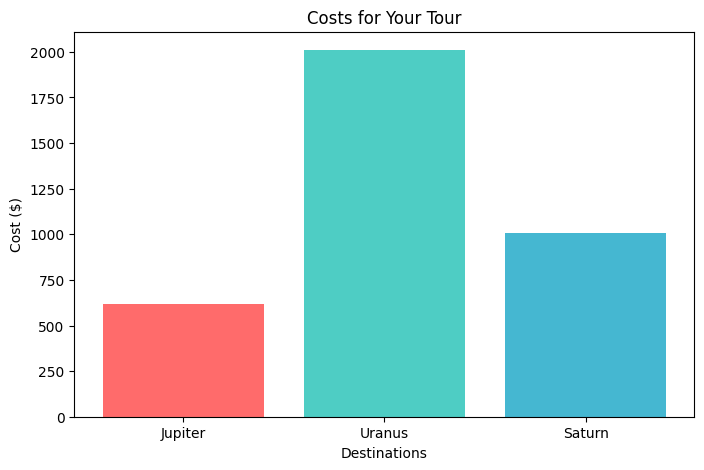

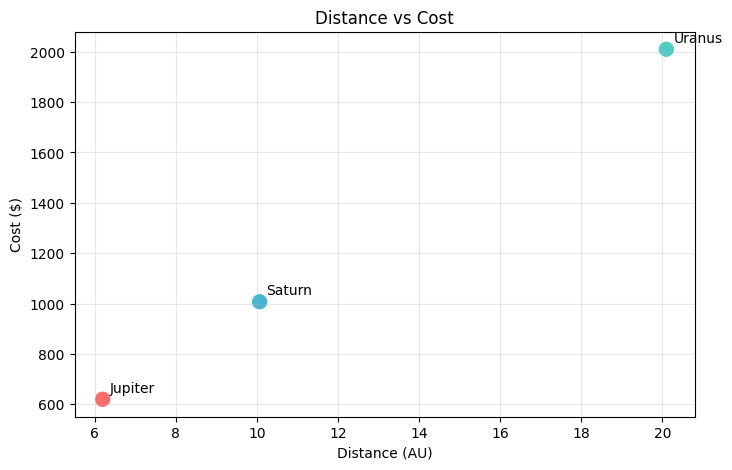

We hope you enjoy these and return to plan your next trip with us too!


In [84]:
#LLM integration
#LLM picks 3 of our 8 destinations and generates 3 activities each based on user input(keywords and constraints, goals)

#this function prompts the LLM to pick 3 of the 8 destinations based on user goals
def llm_pick_destinations(user_goals, available_destinations):
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": f"From these destinations: {[d.name for d in available_destinations]}, pick 3 that best match these goals: '{user_goals}'. Reply with just the 3 names separated by commas."}],
            max_tokens=40,
        )
        return response.choices[0].message.content.strip()
    except:
        return "Mars, Jupiter, Saturn"

#prompts the LLM to generate activities based on user goals
def llm_generate_activities(destination, user_goals, distance, cost):
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": f"Generate 3 activities to be completed on the planet {destination}. Goals: {user_goals}. Budget: ${cost}. Be creative and unique with your activities, but consistent in formatting. Respond ONLY with these 3 lines, no less, nothing else:\n\nActivity1: [name] - [description]\nActivity2: [name] - [description]\nActivity3: [name] - [description]"}],
            max_tokens=150, # high enough to allow LLM to provide complete sentence within token limit. if limit exceeded, may output incomplete sentence, but fixing this results in slow code due to repetetive LLM calls.
            temperature=0.1,  # Very low temperature for consistency
        )
        return response.choices[0].message.content.strip()
    except:
        return f"Activity1: Surface Walk - Explore {destination} terrain\nActivity2: Photo Session - Capture {destination} views\nActivity3: Orbital Tour - See {destination} from space"
        
# user input for goals/constraints
print("Welcome to Space Tourism!")
print("What are your goals/constraints? (e.g., 'budget-friendly', 'luxury experience', 'adventure', 'relaxation')")
#print("Here is your package with some destinations and activities we think you'd enjoy!")
user_goals = input("Your goals: ").strip()

# LLM picks 5 destinations from your 8 options
selected_names = llm_pick_destinations(user_goals, locations)
selected_destinations = [dest for dest in locations if dest.name in selected_names]

# Generate brochures for selected destinations
for dest in selected_destinations:
    # LLM generates 3 activities based on user goals
    activities_text = llm_generate_activities(dest.name, user_goals, dest.distance, dest.cost)

    # Parse activities
    activities = []
    for line in activities_text.split('\n'):
        if 'Activity' in line and ':' in line:
            try:
                name_desc = line.split(':', 1)[1].strip()
                name, desc = name_desc.split(' - ', 1)
                activities.append((name.strip(), desc.strip()))
            except:
                pass

    #fallback if still not 3
    if len(activities) < 3:
        fallbacks = [
            ("Surface Walk", f"Explore {dest.name} terrain"),
            ("Photo Session", f"Capture {dest.name} views"),
            ("Orbital Tour", f"See {dest.name} from space")
        ]
        
    while len(activities) < 3:
        activities.append(fallbacks[len(activities)])

    # Create Activity objects
    act1 = Activity(activities[0][0], "2024-01-15", "10:00", dest.cost * 0.5, activities[0][1])
    act2 = Activity(activities[1][0], "2024-01-16", "14:00", dest.cost * 0.8, activities[1][1])
    act3 = Activity(activities[2][0], "2024-01-17", "09:00", dest.cost * 1.2, activities[2][1])
        
    # Create package
    package = TourPackage(dest, "Budget/VIP", act1, act2, act3, act3)
        
    #print brochure with LLM chosen destinations and activities
    print(f"\n=== {dest.name} Space Tour ===")
    print(f"Distance: {dest.distance} AU | Cost: ${dest.cost}")
    print(f"1. {act1.name} (${act1.cost}): {act1.description}")
    print(f"2. {act2.name} (${act2.cost}): {act2.description}")
    print(f"3. {act3.name} (${act3.cost}): {act3.description}")
    print("-" * 50)
# Execute the visualization with whatever data is available
plot_selected_destinations(selected_destinations, user_goals)

# print closing sentence
print("We hope you enjoy these and return to plan your next trip with us too!")

results and discussion (add below)

individual contribution statement (add below)